## Adam convergence problem

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [3]:
import adashift.optimizers as ad_opt

In [4]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [5]:
def OnlineLearning(optimizer_type='Adam', alpha=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = alpha
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [6]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160437881574 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958796649985 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496171242752423 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069642169266007 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.32442571966003625 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.3125654876726804 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.3034359073735933 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.2961329248513235 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012170080303734 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.2850632473994456 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.280731002208641

In [7]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438381194114684 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818181499004363 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665848134676615 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.1522245525431633 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568643005943298 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354937993208567 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415799653870719 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661422948002815 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.10038345542165968 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512501832294463 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061027578093789 x: -0.99762970209121

In [8]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: 9.873220443725586 regret_avg : 0.463386503688395 x: -0.9873220324516296
step : 100000 loss: 10.0 regret_avg : 0.3262722123773396 x: -1.0
step : 150000 loss: 9.991798400878906 regret_avg : 0.26590045690268277 x: -0.9991798400878906
step : 200000 loss: 9.98381519317627 regret_avg : 0.23001920878209173 x: -0.9983815550804138
step : 250000 loss: 9.977197647094727 regret_avg : 0.20557853314048052 x: -0.9977197647094727
step : 300000 loss: 9.971391677856445 regret_avg : 0.1875609749462704 x: -0.9971391558647156
step : 350000 loss: 9.966115951538086 regret_avg : 0.1735716709588681 x: -0.9966115951538086
step : 400000 loss: 9.961211204528809 regret_avg : 0.1623040677298978 x: -0.9961211085319519
step : 450000 loss: 9.956570625305176 regret_avg : 0.15297691489872006 x: -0.9956570863723755
step : 500000 loss: 9.952126502990723 regret_avg : 0.1450906378223002 x: -0.9952126741409302
step : 550000 loss: 9.947837829589844 regret_avg : 0.1383089264480905 x: -0.9947838187217712
step

Regret should tend to zero. As we can see it is done only for amsgrad.

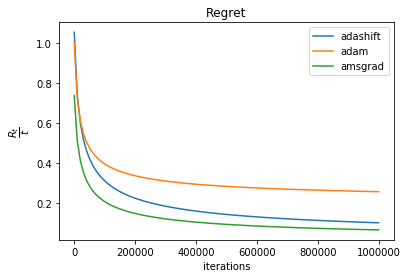

In [9]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

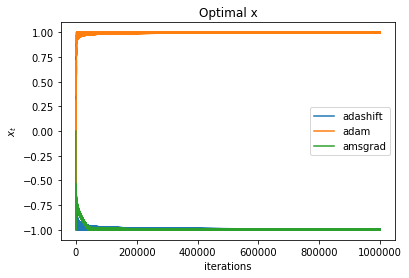

In [10]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [11]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x

In [19]:
def StochLearning(optimizer_type='Adam', alpha=1e-3, lr_decay=True,\
                  eps=1e-10, betas=(0.0, 0.999), amsgrad=False, max_step = 1000001):
    
    x = torch.tensor([0.0], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=alpha, betas=betas, eps=eps, amsgrad=amsgrad)
    else:
        optimizer = ad_opt.AdaShift([x], lr=alpha, keep_num=1, betas=betas, eps=eps)

    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        #x.data = x.data.clamp(-1.0, 1.0)

        loss = stoch_f_t(x, step)

        loss.backward()
        if step % 10000 == 0:
            x_history.append(x.item())
            loss_history.append(loss.item())
            time_steps.append(step)

        if step % 100000 == 0:
            print ('step : ', step, '  loss : ', loss.item(), ' x:', x.item())
                                 
        optimizer.step()   

        if lr_decay:
            scheduler.step()
        
        optimizer.zero_grad()
            
    return time_steps, loss_history, x_history

In [17]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(alpha=lr, lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  0.024470333009958267  x: -0.024470333009958267
step :  200000   loss :  0.2543334662914276  x: -0.2543334662914276
step :  300000   loss :  0.138028085231781  x: -0.138028085231781
step :  400000   loss :  0.194101020693779  x: -0.194101020693779
step :  500000   loss :  -0.19227567315101624  x: 0.19227567315101624
step :  600000   loss :  -0.9761835932731628  x: 0.9761835932731628
step :  700000   loss :  -1.8436503410339355  x: 1.8436503410339355
step :  800000   loss :  -1.9853883981704712  x: 1.9853883981704712
step :  900000   loss :  -2.1280596256256104  x: 2.1280596256256104
step :  1000000   loss :  -2.507331371307373  x: 2.507331371307373
step :  1100000   loss :  -2.4876019954681396  x: 2.4876019954681396
step :  1200000   loss :  -2.6244866847991943  x: 2.6244866847991943
step :  1300000   loss :  -2.7622299194335938  x: 2.7622299194335938
step :  1400000   loss :  -3.1374475955963135  x: 3.1374475955963135
step :  1500000   lo

In [20]:
adashift_time_steps, adashift_loss_history, adashift_x_history = \
                    StochLearning(optimizer_type='Adashift',lr_decay=False, max_step=10000000)

Optimization with Adashift
step :  100000   loss :  0.17434974014759064  x: -0.17434974014759064
step :  200000   loss :  0.40415313839912415  x: -0.40415313839912415
step :  300000   loss :  0.578467845916748  x: -0.578467845916748
step :  400000   loss :  1.0358682870864868  x: -1.0358682870864868
step :  500000   loss :  1.4750570058822632  x: -1.4750570058822632
step :  600000   loss :  1.544525146484375  x: -1.544525146484375
step :  700000   loss :  2.1435563564300537  x: -2.1435563564300537
step :  800000   loss :  2.045781135559082  x: -2.045781135559082
step :  900000   loss :  2.115391731262207  x: -2.115391731262207
step :  1000000   loss :  2.049607753753662  x: -2.049607753753662
step :  1100000   loss :  2.481123447418213  x: -2.481123447418213
step :  1200000   loss :  3.142401933670044  x: -3.142401933670044
step :  1300000   loss :  3.6849310398101807  x: -3.6849310398101807
step :  1400000   loss :  4.084707260131836  x: -4.084707260131836
step :  1500000   loss :  4.

In [21]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(alpha=lr, amsgrad=True, 
                                                                lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  0.054892994463443756  x: -0.054892994463443756
step :  200000   loss :  0.5457460880279541  x: -0.5457460880279541
step :  300000   loss :  0.6191473603248596  x: -0.6191473603248596
step :  400000   loss :  0.316234290599823  x: -0.316234290599823
step :  500000   loss :  0.2916260063648224  x: -0.2916260063648224
step :  600000   loss :  0.16864553093910217  x: -0.16864553093910217
step :  700000   loss :  0.18000690639019012  x: -0.18000690639019012
step :  800000   loss :  0.9851465225219727  x: -0.9851465225219727
step :  900000   loss :  1.0865345001220703  x: -1.0865345001220703
step :  1000000   loss :  1.2040914297103882  x: -1.2040914297103882
step :  1100000   loss :  1.7001928091049194  x: -1.7001928091049194
step :  1200000   loss :  1.723340630531311  x: -1.723340630531311
step :  1300000   loss :  1.7533031702041626  x: -1.7533031702041626
step :  1400000   loss :  1.5515652894973755  x: -1.5515652894973755
step :  1500000 

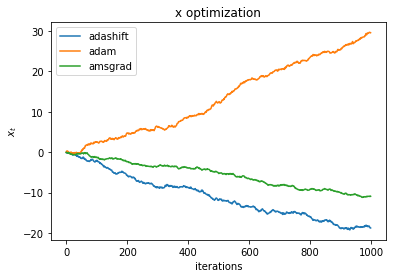

In [22]:
plt.title("x optimization")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

#### Logistic regression on MNIST

In [23]:
import torchvision
import torchvision.transforms as transforms

input_size = 784
num_classes = 10
num_epochs = 200
batch_size = 64

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Processing...
Done!


In [24]:
import torch.nn as nn

model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0)

In [25]:
def train_model(model,criterion, optimizer):
    total_step = len(train_loader)
    loss_hist = []

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss_hist.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item()))
    return loss_hist

In [26]:
adam_loss_hist = train_model(model, criterion, adam_optimizer)

Epoch [1/200], Step [1/938], Loss: 2.2682
Epoch [1/200], Step [101/938], Loss: 0.9228
Epoch [1/200], Step [201/938], Loss: 0.5089
Epoch [1/200], Step [301/938], Loss: 0.5193
Epoch [1/200], Step [401/938], Loss: 0.6311
Epoch [1/200], Step [501/938], Loss: 0.6045
Epoch [1/200], Step [601/938], Loss: 0.4092
Epoch [1/200], Step [701/938], Loss: 0.2408
Epoch [1/200], Step [801/938], Loss: 0.4360
Epoch [1/200], Step [901/938], Loss: 0.3920
Epoch [2/200], Step [1/938], Loss: 0.3513
Epoch [2/200], Step [101/938], Loss: 0.3094
Epoch [2/200], Step [201/938], Loss: 0.2130
Epoch [2/200], Step [301/938], Loss: 0.2775
Epoch [2/200], Step [401/938], Loss: 0.3031
Epoch [2/200], Step [501/938], Loss: 0.2971
Epoch [2/200], Step [601/938], Loss: 0.4997
Epoch [2/200], Step [701/938], Loss: 0.4141
Epoch [2/200], Step [801/938], Loss: 0.3409
Epoch [2/200], Step [901/938], Loss: 0.3936
Epoch [3/200], Step [1/938], Loss: 0.2162
Epoch [3/200], Step [101/938], Loss: 0.2672
Epoch [3/200], Step [201/938], Loss: 0

Epoch [19/200], Step [501/938], Loss: 0.1310
Epoch [19/200], Step [601/938], Loss: 0.1548
Epoch [19/200], Step [701/938], Loss: 0.3048
Epoch [19/200], Step [801/938], Loss: 0.1661
Epoch [19/200], Step [901/938], Loss: 0.0475
Epoch [20/200], Step [1/938], Loss: 0.1538
Epoch [20/200], Step [101/938], Loss: 0.3407
Epoch [20/200], Step [201/938], Loss: 0.1273
Epoch [20/200], Step [301/938], Loss: 0.4976
Epoch [20/200], Step [401/938], Loss: 0.1207
Epoch [20/200], Step [501/938], Loss: 0.0912
Epoch [20/200], Step [601/938], Loss: 0.2469
Epoch [20/200], Step [701/938], Loss: 0.1685
Epoch [20/200], Step [801/938], Loss: 0.1700
Epoch [20/200], Step [901/938], Loss: 0.1680
Epoch [21/200], Step [1/938], Loss: 0.3734
Epoch [21/200], Step [101/938], Loss: 0.2792
Epoch [21/200], Step [201/938], Loss: 0.3992
Epoch [21/200], Step [301/938], Loss: 0.0829
Epoch [21/200], Step [401/938], Loss: 0.2480
Epoch [21/200], Step [501/938], Loss: 0.2237
Epoch [21/200], Step [601/938], Loss: 0.3526
Epoch [21/200]

Epoch [37/200], Step [801/938], Loss: 0.1532
Epoch [37/200], Step [901/938], Loss: 0.1740
Epoch [38/200], Step [1/938], Loss: 0.1621
Epoch [38/200], Step [101/938], Loss: 0.2011
Epoch [38/200], Step [201/938], Loss: 0.1803
Epoch [38/200], Step [301/938], Loss: 0.3731
Epoch [38/200], Step [401/938], Loss: 0.2501
Epoch [38/200], Step [501/938], Loss: 0.1622
Epoch [38/200], Step [601/938], Loss: 0.1810
Epoch [38/200], Step [701/938], Loss: 0.0594
Epoch [38/200], Step [801/938], Loss: 0.3548
Epoch [38/200], Step [901/938], Loss: 0.1973
Epoch [39/200], Step [1/938], Loss: 0.1032
Epoch [39/200], Step [101/938], Loss: 0.2674
Epoch [39/200], Step [201/938], Loss: 0.3951
Epoch [39/200], Step [301/938], Loss: 0.2452
Epoch [39/200], Step [401/938], Loss: 0.4797
Epoch [39/200], Step [501/938], Loss: 0.5188
Epoch [39/200], Step [601/938], Loss: 0.3902
Epoch [39/200], Step [701/938], Loss: 0.1831
Epoch [39/200], Step [801/938], Loss: 0.3150
Epoch [39/200], Step [901/938], Loss: 0.1392
Epoch [40/200]

Epoch [56/200], Step [101/938], Loss: 0.3162
Epoch [56/200], Step [201/938], Loss: 0.0772
Epoch [56/200], Step [301/938], Loss: 0.1599
Epoch [56/200], Step [401/938], Loss: 0.1121
Epoch [56/200], Step [501/938], Loss: 0.3627
Epoch [56/200], Step [601/938], Loss: 0.1161
Epoch [56/200], Step [701/938], Loss: 0.1901
Epoch [56/200], Step [801/938], Loss: 0.1282
Epoch [56/200], Step [901/938], Loss: 0.1519
Epoch [57/200], Step [1/938], Loss: 0.1830
Epoch [57/200], Step [101/938], Loss: 0.1694
Epoch [57/200], Step [201/938], Loss: 0.1181
Epoch [57/200], Step [301/938], Loss: 0.1516
Epoch [57/200], Step [401/938], Loss: 0.1316
Epoch [57/200], Step [501/938], Loss: 0.1918
Epoch [57/200], Step [601/938], Loss: 0.2280
Epoch [57/200], Step [701/938], Loss: 0.2475
Epoch [57/200], Step [801/938], Loss: 0.4010
Epoch [57/200], Step [901/938], Loss: 0.1130
Epoch [58/200], Step [1/938], Loss: 0.2256
Epoch [58/200], Step [101/938], Loss: 0.1653
Epoch [58/200], Step [201/938], Loss: 0.2008
Epoch [58/200]

KeyboardInterrupt: 

In [46]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

ams_loss_hist = train_model(model, criterion, amsgrad_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3129
Epoch [1/5], Step [101/469], Loss: 0.7497
Epoch [1/5], Step [201/469], Loss: 0.5527
Epoch [1/5], Step [301/469], Loss: 0.3873
Epoch [1/5], Step [401/469], Loss: 0.3741
Epoch [2/5], Step [1/469], Loss: 0.3965
Epoch [2/5], Step [101/469], Loss: 0.3368
Epoch [2/5], Step [201/469], Loss: 0.3231
Epoch [2/5], Step [301/469], Loss: 0.3286
Epoch [2/5], Step [401/469], Loss: 0.2998
Epoch [3/5], Step [1/469], Loss: 0.2921
Epoch [3/5], Step [101/469], Loss: 0.3372
Epoch [3/5], Step [201/469], Loss: 0.3200
Epoch [3/5], Step [301/469], Loss: 0.2950
Epoch [3/5], Step [401/469], Loss: 0.3556
Epoch [4/5], Step [1/469], Loss: 0.2234
Epoch [4/5], Step [101/469], Loss: 0.3888
Epoch [4/5], Step [201/469], Loss: 0.2573
Epoch [4/5], Step [301/469], Loss: 0.2937
Epoch [4/5], Step [401/469], Loss: 0.2395
Epoch [5/5], Step [1/469], Loss: 0.2106
Epoch [5/5], Step [101/469], Loss: 0.2355
Epoch [5/5], Step [201/469], Loss: 0.3712
Epoch [5/5], Step [301/469], Loss: 0.3334
Ep

In [49]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-2,\
                             betas=(0.0, 0.999), eps=1e-8)

adashift_loss_hist = train_model(model, criterion, adashift_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3321
Epoch [1/5], Step [101/469], Loss: 1.4465
Epoch [1/5], Step [201/469], Loss: 1.0807
Epoch [1/5], Step [301/469], Loss: 0.8524
Epoch [1/5], Step [401/469], Loss: 0.7565
Epoch [2/5], Step [1/469], Loss: 0.6515
Epoch [2/5], Step [101/469], Loss: 0.5573
Epoch [2/5], Step [201/469], Loss: 0.5489
Epoch [2/5], Step [301/469], Loss: 0.6696
Epoch [2/5], Step [401/469], Loss: 0.6332
Epoch [3/5], Step [1/469], Loss: 0.3607
Epoch [3/5], Step [101/469], Loss: 0.5934
Epoch [3/5], Step [201/469], Loss: 0.3756
Epoch [3/5], Step [301/469], Loss: 0.4932
Epoch [3/5], Step [401/469], Loss: 0.4231
Epoch [4/5], Step [1/469], Loss: 0.3594
Epoch [4/5], Step [101/469], Loss: 0.3689
Epoch [4/5], Step [201/469], Loss: 0.4349
Epoch [4/5], Step [301/469], Loss: 0.3094
Epoch [4/5], Step [401/469], Loss: 0.4228
Epoch [5/5], Step [1/469], Loss: 0.3735
Epoch [5/5], Step [101/469], Loss: 0.3209
Epoch [5/5], Step [201/469], Loss: 0.3687
Epoch [5/5], Step [301/469], Loss: 0.2852
Ep

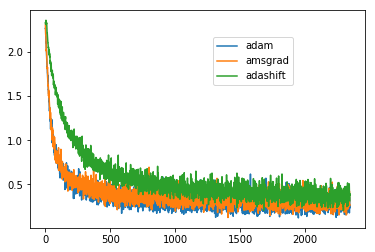

In [52]:
plt.plot(adam_loss_hist, label="adam")
plt.plot(ams_loss_hist, label="amsgrad")
plt.plot(adashift_loss_hist, label="adashift")

plt.legend(bbox_to_anchor=(0.8, 0.9), loc='best')
plt.show()